# myChemometrix

#### import packages

In [2648]:
import os
import sys
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import cross_val_predict, GridSearchCV
from scipy.stats import f
import numpy as np
from scipy.spatial.distance import cdist
from scipy.signal import savgol_filter

# from sklearn.model_selection import train_test_split, cross_val_predict, GroupKFold, KFold


plt.rcParams["figure.figsize"] = (12, 6)

### Import Data File (csv, xlsx)

In [2649]:
file_path = (os.getcwd() + '/data/spectra CE801 corrected.xlsx')
print('file path:', file_path)

file path: /media/bs/bs/pythonProjects/myChemometrics/data/spectra CE801 corrected.xlsx


### Save data as Pandas Dataframe

In [2650]:
if file_path.endswith('.csv'):
    df_raw = pd.read_csv(file_path, encoding='utf-8')
elif file_path.endswith('.xlsx'):
    df_raw = pd.read_excel(file_path)

### Inspect Raw Data

In [2651]:
print(f'Number of rows: {df_raw.shape[0]} \nNumber of columns: {df_raw.shape[1]}')

print('\nDisplay the first 5 rows of the data:')
display(df_raw.head(5))

Number of rows: 2147 
Number of columns: 114

Display the first 5 rows of the data:


,DateTime,spec #,SpecName,FluidT,SpectrT,ExpTime,start time,end time,test #,H2O2,...,1036,1038.5,1041,1043.5,1046,1048.5,1051,1053.5,1056,1058.5
0,2024-05-07 11:08:05,1,S7244,23.15,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085526,-0.091284,-0.096095,-0.099885,-0.102702,-0.104562,-0.105331,-0.104882,-0.103389,-0.101129
1,2024-05-07 11:08:11,2,S7245,23.15,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085513,-0.091278,-0.096091,-0.099880,-0.102692,-0.104551,-0.105322,-0.104873,-0.103375,-0.101111
2,2024-05-07 11:08:17,3,S7246,23.15,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085530,-0.091299,-0.096108,-0.099888,-0.102688,-0.104529,-0.105290,-0.104838,-0.103345,-0.101085
3,2024-05-07 11:08:23,4,S7247,23.10,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085500,-0.091273,-0.096092,-0.099884,-0.102696,-0.104542,-0.105296,-0.104835,-0.103333,-0.101065
4,2024-05-07 11:08:29,5,S7248,23.10,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085476,-0.091255,-0.096079,-0.099880,-0.102707,-0.104575,-0.105347,-0.104893,-0.103383,-0.101101


#### Remove non-numerical columns

In [2652]:
df_raw = df_raw.select_dtypes(include=['number'])
df_raw.head(5)

,spec #,FluidT,SpectrT,ExpTime,test #,H2O2,Cu,pH,A,H2O,...,1036,1038.5,1041,1043.5,1046,1048.5,1051,1053.5,1056,1058.5
0,1,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085526,-0.091284,-0.096095,-0.099885,-0.102702,-0.104562,-0.105331,-0.104882,-0.103389,-0.101129
1,2,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085513,-0.091278,-0.096091,-0.099880,-0.102692,-0.104551,-0.105322,-0.104873,-0.103375,-0.101111
2,3,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085530,-0.091299,-0.096108,-0.099888,-0.102688,-0.104529,-0.105290,-0.104838,-0.103345,-0.101085
3,4,23.10,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085500,-0.091273,-0.096092,-0.099884,-0.102696,-0.104542,-0.105296,-0.104835,-0.103333,-0.101065
4,5,23.10,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085476,-0.091255,-0.096079,-0.099880,-0.102707,-0.104575,-0.105347,-0.104893,-0.103383,-0.101101


### Check for empty cells and remove if exist

In [2653]:
flag_na = df_raw.isnull().any().any()

print(f'Any empty cells in DataFrame: {flag_na}')

if flag_na:
    df_raw = df_raw.dropna()    
    print(f'Number of rows: {df_raw.shape[0]} \nNumber of columns: {df_raw.shape[1]}')
    print('\nDisplay the first 5 rows of the data:')
    display(df_raw.head(5))

Any empty cells in DataFrame: False


### Equalize the data grouped by a label while keeping the distrabution of the measurements

In [2654]:
def equalize_group_size(df, group_column):
    # Group the DataFrame according to the specific column
    grouped = df.groupby(group_column)
    
    # Determine the size of the smallest group
    min_group_size = grouped.size().min()
    
    # Sample data from each group to make them the same size
    equalized_data = []
    for _, group_data in grouped:
        equalized_data.append(group_data.sample(n=min_group_size, random_state=None))
    
    # Concatenate the sampled data into a new DataFrame
    equalized_df = pd.concat(equalized_data)
    
    return equalized_df


# Equalize group size while preserving distribution
# df_raw = equalize_group_size(df_raw, 'H2O2').reset_index(drop=True)

### Seperate raw data to features matrix X and targets matrix y 

* Features matrix X

1. list numeric headers from the raw dataframe

In [2655]:
# Check if the column headers are numeric
numeric_columns = [col for col in df_raw.columns if isinstance(col, (int, float))]

print(f'list of numeric headers:\n{numeric_columns}')

list of numeric headers:
[811, 813.5, 816, 818.5, 821, 823.5, 826, 828.5, 831, 833.5, 836, 838.5, 841, 843.5, 846, 848.5, 851, 853.5, 856, 858.5, 861, 863.5, 866, 868.5, 871, 873.5, 876, 878.5, 881, 883.5, 886, 888.5, 891, 893.5, 896, 898.5, 901, 903.5, 906, 908.5, 911, 913.5, 916, 918.5, 921, 923.5, 926, 928.5, 931, 933.5, 936, 938.5, 941, 943.5, 946, 948.5, 951, 953.5, 956, 958.5, 961, 963.5, 966, 968.5, 971, 973.5, 976, 978.5, 981, 983.5, 986, 988.5, 991, 993.5, 996, 998.5, 1001, 1003.5, 1006, 1008.5, 1011, 1013.5, 1016, 1018.5, 1021, 1023.5, 1026, 1028.5, 1031, 1033.5, 1036, 1038.5, 1041, 1043.5, 1046, 1048.5, 1051, 1053.5, 1056, 1058.5]


 2. remove unwanted columns if needed

In [2656]:
# uncomment if removing is needed

# # Values to remove
# values_to_remove = [811, 986]

# # Create a new list excluding the values to remove
# numeric_columns = [item for item in numeric_columns if item not in values_to_remove]

selected_x_columns = numeric_columns

3. create features matrix X

In [2657]:
X = df_raw[selected_x_columns]
print(f'Number of rows: {X.shape[0]} \nNumber of columns: {X.shape[1]}')
print('\nDisplay the first 5 rows of the data:')
display(X.head(5))

Number of rows: 2147 
Number of columns: 100

Display the first 5 rows of the data:


,811.0,813.5,816.0,818.5,821.0,823.5,826.0,828.5,831.0,833.5,...,1036.0,1038.5,1041.0,1043.5,1046.0,1048.5,1051.0,1053.5,1056.0,1058.5
0,-0.016455,-0.016218,-0.015843,-0.015277,-0.014390,-0.013066,-0.011343,-0.009393,-0.007441,-0.005761,...,-0.085526,-0.091284,-0.096095,-0.099885,-0.102702,-0.104562,-0.105331,-0.104882,-0.103389,-0.101129
1,-0.016460,-0.016223,-0.015847,-0.015279,-0.014391,-0.013067,-0.011345,-0.009394,-0.007442,-0.005759,...,-0.085513,-0.091278,-0.096091,-0.099880,-0.102692,-0.104551,-0.105322,-0.104873,-0.103375,-0.101111
2,-0.016467,-0.016231,-0.015856,-0.015289,-0.014400,-0.013075,-0.011353,-0.009402,-0.007448,-0.005765,...,-0.085530,-0.091299,-0.096108,-0.099888,-0.102688,-0.104529,-0.105290,-0.104838,-0.103345,-0.101085
3,-0.016460,-0.016224,-0.015849,-0.015283,-0.014395,-0.013071,-0.011349,-0.009398,-0.007446,-0.005764,...,-0.085500,-0.091273,-0.096092,-0.099884,-0.102696,-0.104542,-0.105296,-0.104835,-0.103333,-0.101065
4,-0.016463,-0.016226,-0.015850,-0.015284,-0.014396,-0.013071,-0.011350,-0.009401,-0.007449,-0.005766,...,-0.085476,-0.091255,-0.096079,-0.099880,-0.102707,-0.104575,-0.105347,-0.104893,-0.103383,-0.101101


* Labels matrix y

1. list non-numeric headers from the raw dataframe

In [2658]:
# Check if the column headers are non-numeric
non_numeric_columns = [col for col in df_raw.columns if not isinstance(col, (int, float))]

print(non_numeric_columns)

['spec #', 'FluidT', 'SpectrT', 'ExpTime', 'test #', 'H2O2', 'Cu', 'pH', 'A', 'H2O']


 2. remove unwanted columns if needed

In [2659]:
# uncomment if removing is needed

# Values to remove
values_to_remove = ['spec #', 'test #']

# Create a new list excluding the values to remove
non_numeric_columns = [item for item in non_numeric_columns if item not in values_to_remove] 

selected_y_columns = non_numeric_columns

In [2660]:
y = df_raw[selected_y_columns]
print(f'Number of rows: {y.shape[0]} \nNumber of columns: {y.shape[1]}')
print('\nDisplay the first 5 rows of the data:')
display(y.head(5))

Number of rows: 2147 
Number of columns: 8

Display the first 5 rows of the data:


,FluidT,SpectrT,ExpTime,H2O2,Cu,pH,A,H2O
0,23.15,37.25,0.048,0.4969,0.0,4.888,3.0,96.5031
1,23.15,37.25,0.048,0.4969,0.0,4.888,3.0,96.5031
2,23.15,37.25,0.048,0.4969,0.0,4.888,3.0,96.5031
3,23.10,37.25,0.048,0.4969,0.0,4.888,3.0,96.5031
4,23.10,37.25,0.048,0.4969,0.0,4.888,3.0,96.5031


## Statistical and visual inspection

* X statistical information:

In [2661]:
X.describe()

,811.0,813.5,816.0,818.5,821.0,823.5,826.0,828.5,831.0,833.5,...,1036.0,1038.5,1041.0,1043.5,1046.0,1048.5,1051.0,1053.5,1056.0,1058.5
count,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,...,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000
mean,0.029071,0.026251,0.023627,0.021253,0.019275,0.017822,0.016885,0.016298,0.015836,0.015243,...,-0.116872,-0.123501,-0.129112,-0.133661,-0.137198,-0.139728,-0.141136,-0.141176,-0.139862,-0.137430
std,0.036551,0.034080,0.031667,0.029317,0.027039,0.024842,0.022738,0.020727,0.018811,0.016989,...,0.025769,0.026479,0.027173,0.027857,0.028531,0.029192,0.029833,0.030340,0.030574,0.030500
min,-0.016467,-0.016231,-0.015856,-0.015298,-0.014423,-0.013111,-0.011400,-0.009461,-0.007519,-0.005844,...,-0.179471,-0.187928,-0.195339,-0.201674,-0.206969,-0.212972,-0.219900,-0.224404,-0.225967,-0.224841
25%,-0.015886,-0.015639,-0.015278,-0.014756,-0.013927,-0.012682,-0.011041,-0.009172,-0.007287,-0.005610,...,-0.118098,-0.124674,-0.130190,-0.134616,-0.138012,-0.140389,-0.141653,-0.141566,-0.140134,-0.137601
50%,0.029799,0.026945,0.024281,0.021851,0.019805,0.018274,0.017260,0.016599,0.016071,0.015423,...,-0.117357,-0.123979,-0.129557,-0.134065,-0.137553,-0.140019,-0.141349,-0.141306,-0.139912,-0.137406
75%,0.029879,0.027018,0.024345,0.021911,0.019868,0.018350,0.017350,0.016703,0.016184,0.015537,...,-0.085209,-0.091007,-0.095839,-0.099634,-0.102482,-0.104385,-0.105186,-0.104757,-0.103275,-0.101025
max,0.118189,0.109558,0.101245,0.093321,0.085965,0.079323,0.073398,0.068028,0.063004,0.058076,...,-0.084400,-0.090233,-0.095043,-0.098776,-0.101499,-0.103244,-0.103932,-0.103450,-0.101928,-0.099658


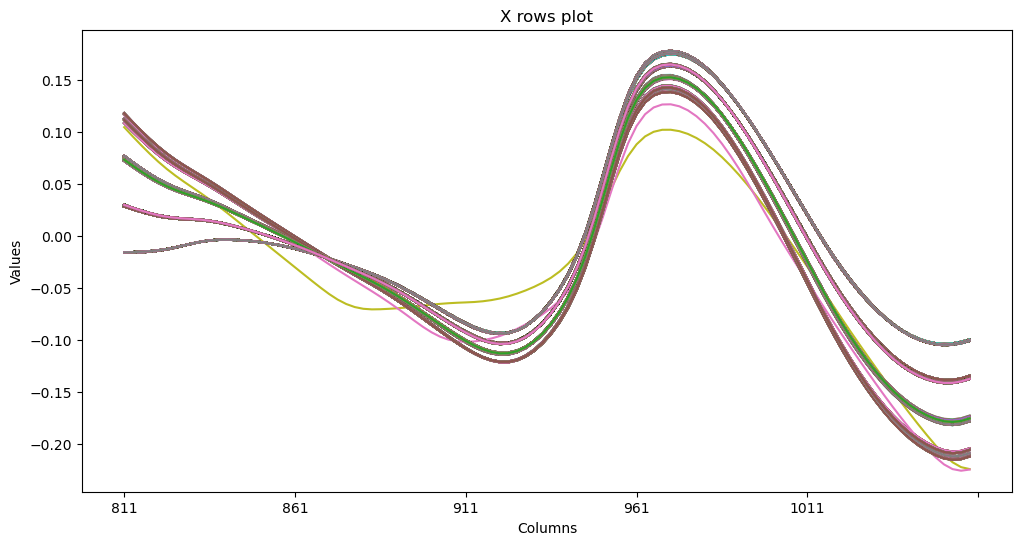

In [2662]:
X.T.plot(title='X rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

* y statistical information:

In [2663]:
y.describe()

,FluidT,SpectrT,ExpTime,H2O2,Cu,pH,A,H2O
count,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000
mean,23.148575,37.563838,0.604647,1.215234,709.380621,4.559796,3.401058,95.383708
std,0.610297,0.407527,0.830257,0.472592,591.269573,0.310400,0.315256,0.614793
min,21.630000,36.690000,0.043000,0.496900,0.000000,3.981000,2.885613,94.271214
25%,22.940000,37.310000,0.048000,0.897600,0.000000,4.508000,3.000000,94.715698
50%,23.190000,37.560000,0.362000,1.049100,700.000000,4.536000,3.482989,95.602400
75%,23.560000,37.810000,0.377000,1.689800,700.000000,4.876000,3.500000,95.602400
max,24.870000,38.440000,10.000000,2.114400,1990.530895,5.174000,4.000000,96.503100


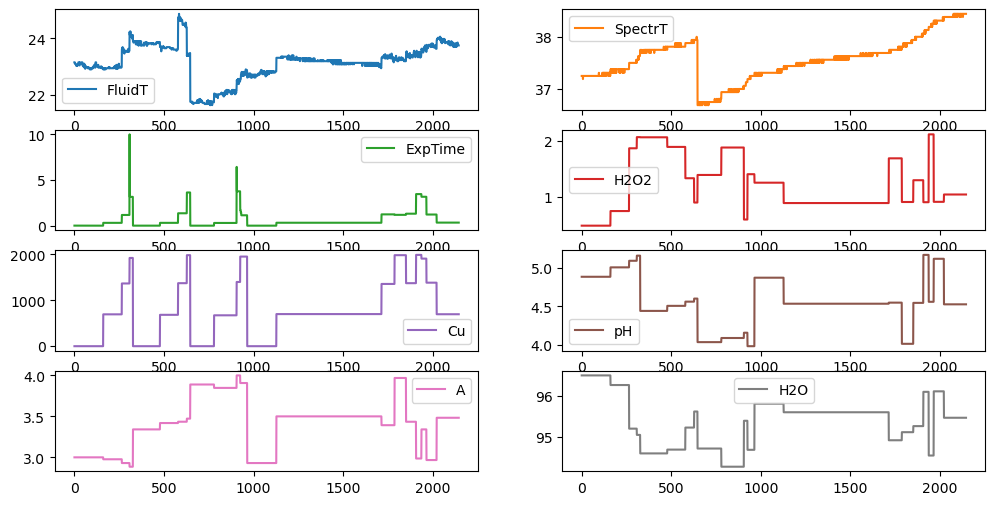

In [2664]:
fig, axes = plt.subplots(nrows=4, ncols=2)
y.plot(subplots=True, ax=axes)
plt.show()

## Removing visual anomalies

1. Evaluate similarities using correlation-distance

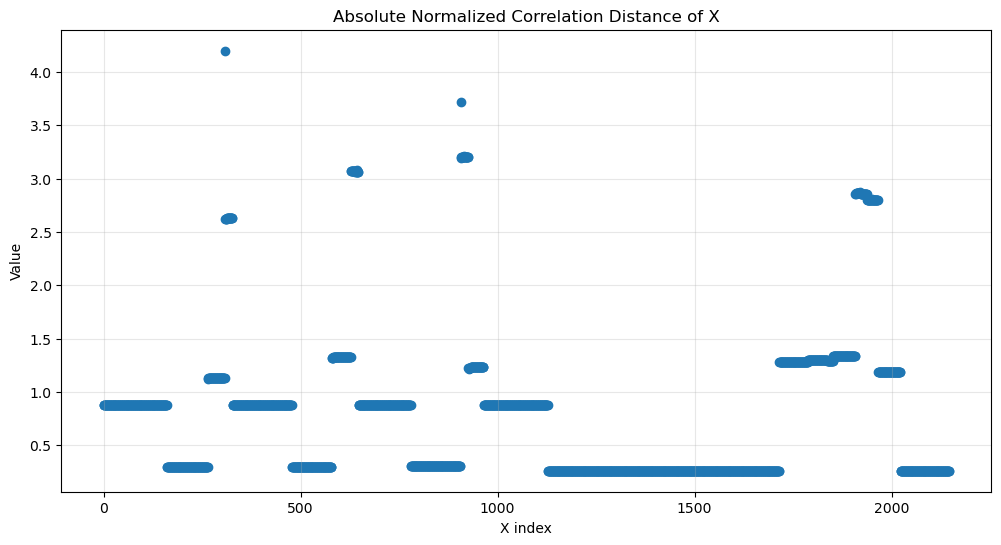

In [2665]:
dissimilarities = cdist(X, X, metric="correlation")
absolute_normalized_dissimilarities_vector = (np.abs((dissimilarities[1] - np.mean(dissimilarities[1])) / np.std(dissimilarities[1])))

plt.scatter(X.index, absolute_normalized_dissimilarities_vector)
plt.title('Absolute Normalized Correlation Distance of X')
plt.xlabel('X index')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

2. Remove rows with values above threshold 

In [2666]:
corr_dist_threshold = 2
rows_to_remove = np.where(absolute_normalized_dissimilarities_vector > corr_dist_threshold)[0]
print(f'Rows to remove from data: {rows_to_remove}')

Rows to remove from data: [ 308  309  310  311  312  313  314  315  316  317  318  319  320  321
  322  323  324  325  326  628  629  630  631  632  633  634  635  636
  637  638  639  640  641  642  643  644  645  646  906  907  908  909
  910  911  912  913  914  915  916  917  918  919  920  921  922  923
  924  925 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919
 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965]


3. Remove rows from X and y

In [2667]:
X_filtered = X.drop(index=rows_to_remove)
y_filtered = y.drop(index=rows_to_remove)

In [2668]:
print(f'Number of rows remained: {X_filtered.shape[0]}')

Number of rows remained: 2031


4. Visual inspection

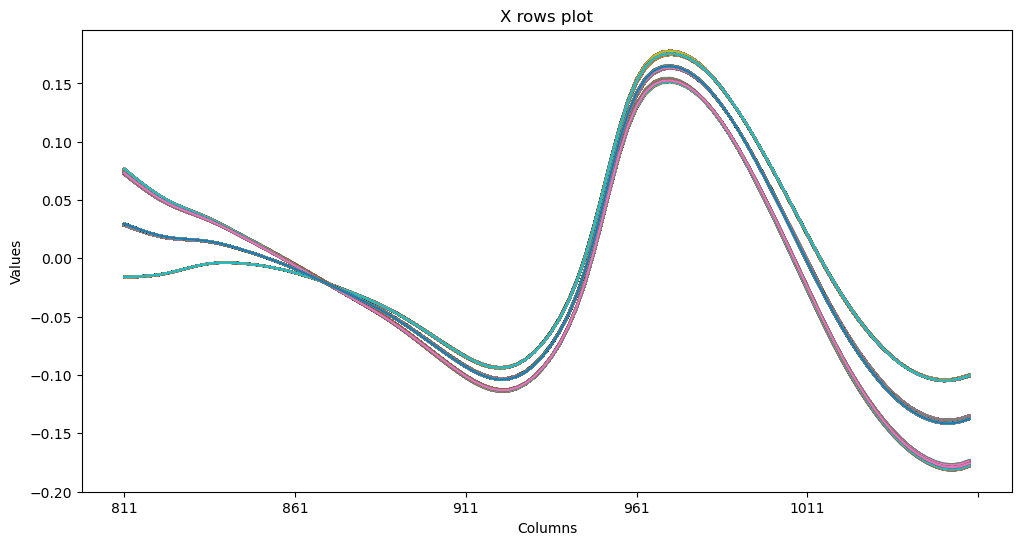

In [2669]:
X_filtered.T.plot(title='X rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

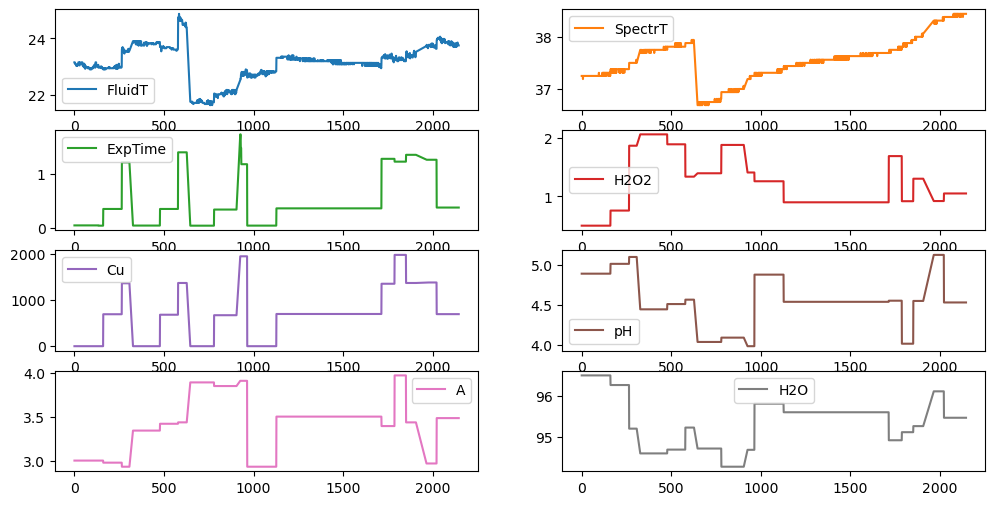

In [2670]:
fig, axes = plt.subplots(nrows=4, ncols=2)
y_filtered.plot(subplots=True, ax=axes)
plt.show()

## Apply MSC

## Calulating 1st and 2nd orders derivatives 

In [2671]:
# Calculate derivatives
X1 = pd.DataFrame(savgol_filter(X_filtered, 11, polyorder = 2, deriv=1), columns=X.columns)
X2 = pd.DataFrame(savgol_filter(X_filtered, 11, polyorder = 2,deriv=2), columns=X.columns)

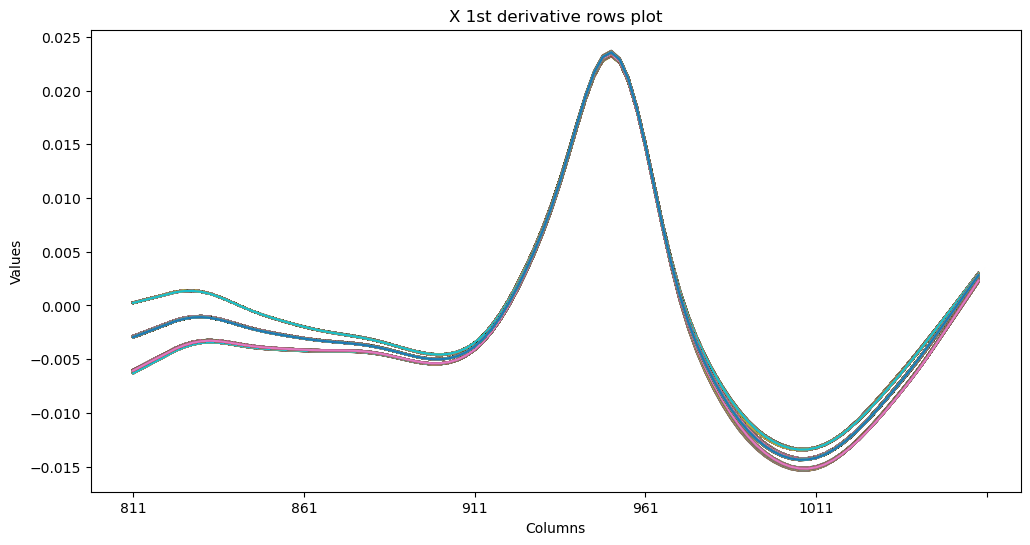

In [2672]:
X1.T.plot(title='X 1st derivative rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

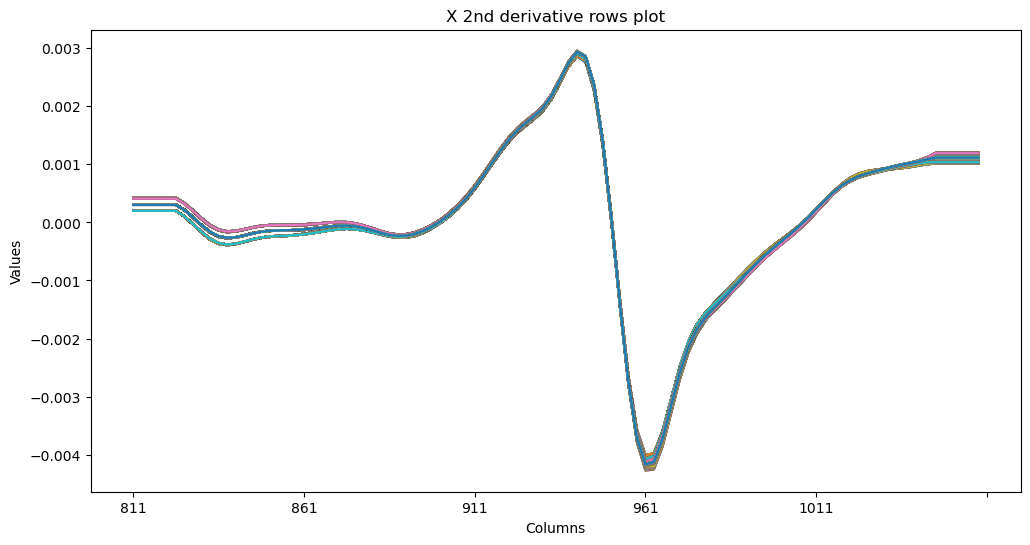

In [2673]:
X2.T.plot(title='X 2nd derivative rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

## Spliting the data into training and testing subsets

1. Define Group K-fold for the splitting train and test datasets

In [2674]:
group_by = 'H2O2'
total_number_of_groups = y_filtered[group_by].nunique()
test_groups_ratio = 0.4
total_test_groups = int(np.ceil(total_number_of_groups/test_groups_ratio/10)) 

print(f'Total number of groups of label "{group_by}" = {total_number_of_groups}')
print(f'Total number of test groups = {total_test_groups}')

# Define GroupKFold
gkf_test = GroupKFold(n_splits=total_test_groups)

Total number of groups of label "H2O2" = 16
Total number of test groups = 4


2. split the data into train and test datasets

In [2675]:
chosen_X = X_filtered
chosen_y = y_filtered

for train_index, test_index in gkf_test.split(chosen_X, chosen_y, chosen_y[group_by]):
    x_train, x_test = chosen_X.iloc[train_index], chosen_X.iloc[test_index]
    y_train, y_test = chosen_y.iloc[train_index], chosen_y.iloc[test_index]

* summary

In [2676]:
print('Total data: ', x_train.shape[0] + x_test.shape[0])
print('Train data: ', x_train.shape[0])
print('Test data: ', x_test.shape[0])

Total data:  2031
Train data:  1544
Test data:  487


## Standardize the data using StandardScaler

* Create StandardScaler instance for train,cv and test data

In [2677]:
########################## -- uncomment to scale -- #############################################
# # Initialize StandardScaler
# scaler = StandardScaler()

# # Fit the scaler on the data and transform the data
# y_train_scaled = scaler.fit_transform(y_train)
# x_train_scaled = scaler.fit_transform(x_train.T)

# y_test_scaled = scaler.fit_transform(y_test)
# x_test_scaled = scaler.fit_transform(x_test.T)

# # Convert the scaled data back to a DataFrame with original column names
# y_train_scaled = pd.DataFrame(y_train_scaled, columns=y.columns)
# x_train_scaled = pd.DataFrame(x_train_scaled.T, columns=X.columns)

# y_test_scaled = pd.DataFrame(y_test_scaled, columns=y.columns)
# x_test_scaled = pd.DataFrame(x_test_scaled.T, columns=X.columns)

##################################### -- comment to scale -- ##################################################

y_train_scaled = pd.DataFrame(y_train, columns=y.columns)
x_train_scaled = pd.DataFrame(x_train, columns=X.columns)

y_test_scaled = pd.DataFrame(y_test, columns=y.columns)
x_test_scaled = pd.DataFrame(x_test, columns=X.columns)

* X Train set

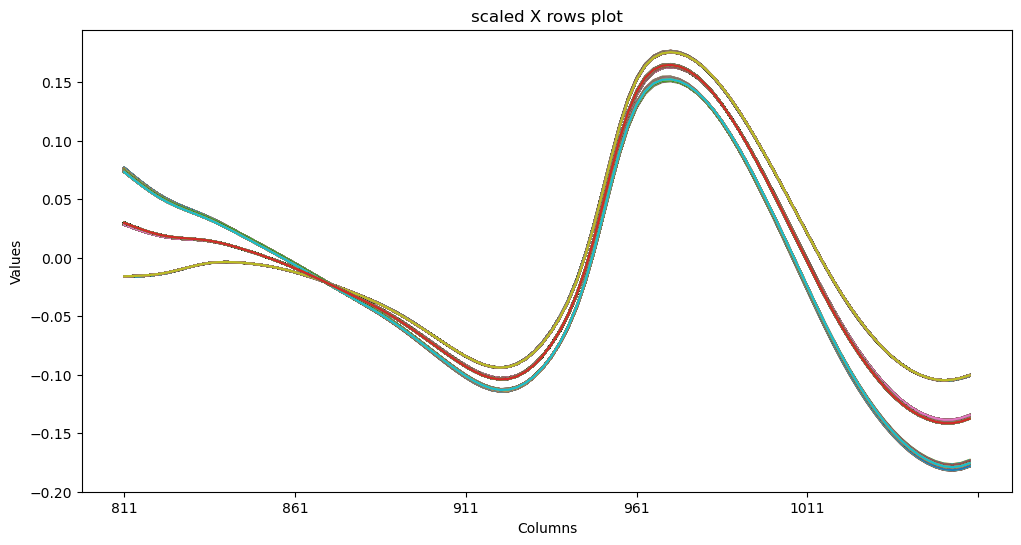

In [2678]:
x_train_scaled.T.plot(title='scaled X rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

* X test set

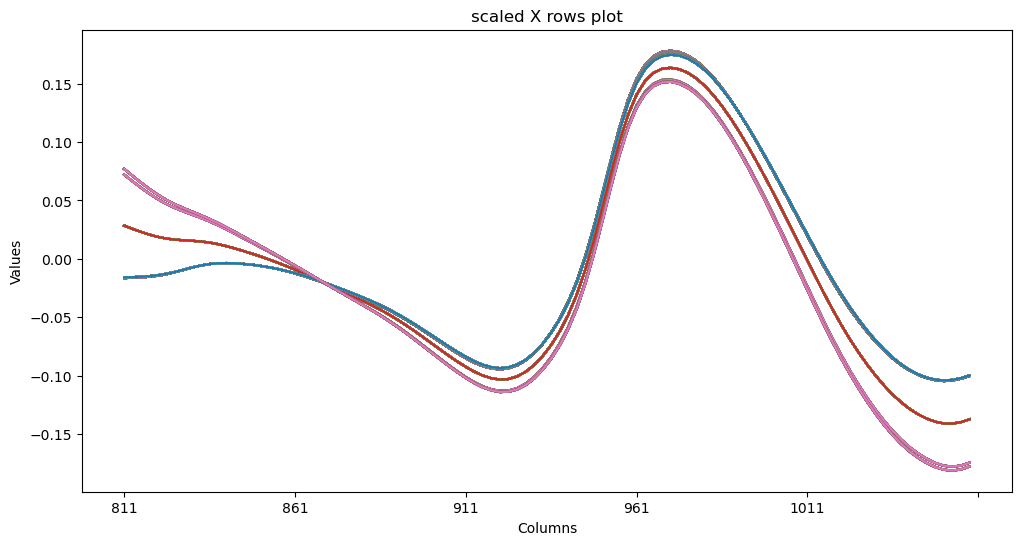

In [2679]:
x_test_scaled.T.plot(title='scaled X rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

* y train set

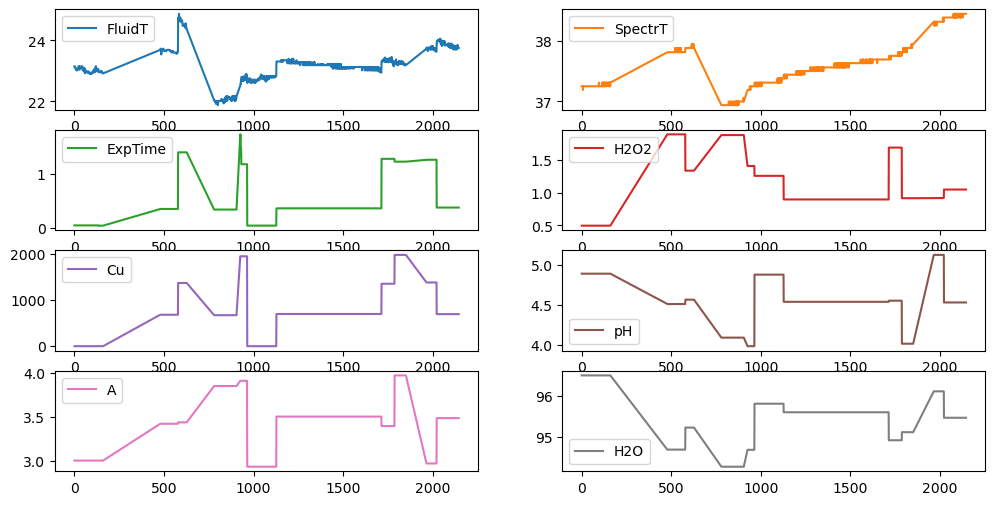

In [2680]:
fig, axes = plt.subplots(nrows=4, ncols=2)
y_train_scaled.plot(subplots=True, ax=axes)
plt.show()

* y test set

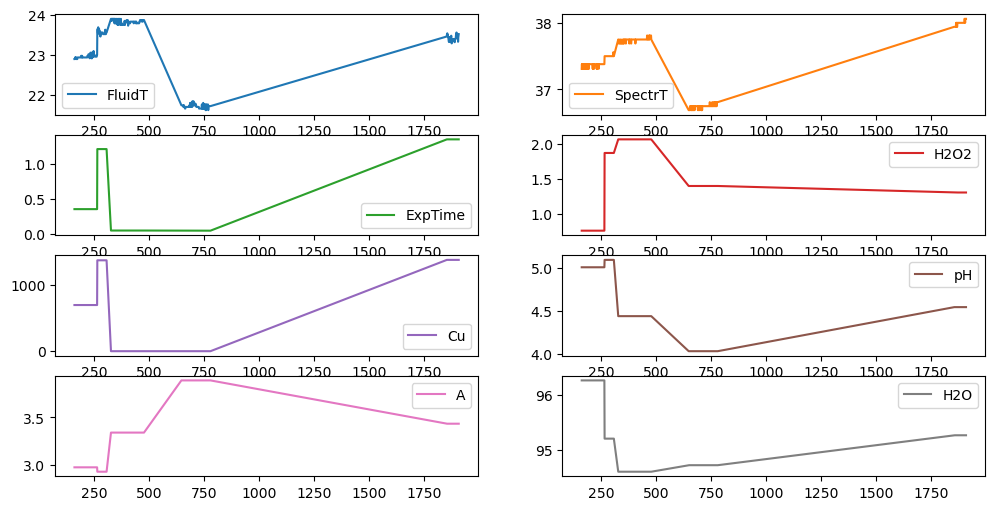

In [2681]:
fig, axes = plt.subplots(nrows=4, ncols=2)
y_test_scaled.plot(subplots=True, ax=axes)
plt.show()

# PLS Regression

#### Select the labels to apply the model on

In [2682]:
print(y.columns.tolist())

['FluidT', 'SpectrT', 'ExpTime', 'H2O2', 'Cu', 'pH', 'A', 'H2O']


In [2683]:
selected_labels = ['H2O2']
label_to_display = 'H2O2'
x_pls = x_train
y_pls = y_train[selected_labels]
y_pls_test = y_test[selected_labels] 

print(f'The features matrix to be modeled x_pls shape: {x_pls.shape}')
print(f'The labels matrix to be modeled y_pls shape: {y_pls.shape}')

The features matrix to be modeled x_pls shape: (1544, 100)
The labels matrix to be modeled y_pls shape: (1544, 1)


### Finding the best number of components for the model

1. Define the parameter space for the search

In [2684]:
parameters = {'n_components':np.arange(1,20,1)}

2. Define the grid-search estimator based on PLS regression

* define group k-fold

In [2685]:
# Define GroupKFold cross-validation
group_kfold = GroupKFold(n_splits=y_pls[label_to_display].nunique())
print(f'Group K-Fold: {group_kfold}')

Group K-Fold: GroupKFold(n_splits=11)


In [2686]:
pls = GridSearchCV(PLSRegression(scale=True), parameters, scoring = 'neg_mean_squared_error', verbose=1, cv=group_kfold)

3. fit the model to the training data

In [2687]:
pls.fit(x_pls, y_pls, groups=y_pls[label_to_display])

Fitting 11 folds for each of 19 candidates, totalling 209 fits


GridSearchCV(cv=GroupKFold(n_splits=11), estimator=PLSRegression(),
             param_grid={'n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='neg_mean_squared_error', verbose=1)

4. The best estimator result

In [2688]:
print(f'The number of components for the PLS model: \n{pls.best_estimator_}')

The number of components for the PLS model: 
PLSRegression(n_components=9)


4. Self prediction results

In [2689]:
y_pred_train = pls.predict(x_pls)
y_pred_train = pd.DataFrame(y_pred_train, columns=selected_labels)

print(f'The self prediction matrix y_pred_train shape: {y_pred_train.shape}')

The self prediction matrix y_pred_train shape: (1544, 1)


In [2690]:
rmse_train, r2_train = np.sqrt(mean_squared_error(y_pls[label_to_display], y_pred_train[label_to_display])), r2_score(y_pls[label_to_display], y_pred_train[label_to_display])

### Applying cross validation for the model using the best estimator

1. Apply the best estimator to calculate a cross-validation predicted variable

In [2691]:
y_pred_cv = cross_val_predict(pls.best_estimator_, x_pls, y_pls, groups=y_pls[label_to_display], cv=group_kfold)
y_pred_cv = pd.DataFrame(y_pred_cv, columns=selected_labels)

print(f'The cross-validation prediction matrix y_cv shape: {y_pred_cv.shape}')

The cross-validation prediction matrix y_cv shape: (1544, 1)


2. Calculate figures of merit

In [2692]:
rmse_cv, r2_cv = np.sqrt(mean_squared_error(y_pls[label_to_display], y_pred_cv[label_to_display])), r2_score(y_pls[label_to_display], y_pred_cv[label_to_display])

### Validating the model using Test dataset

In [2693]:
y_pred_test = pls.predict(x_test)
y_pred_test = pd.DataFrame(y_pred_test, columns=selected_labels)

In [2694]:
rmse_test, r2_test = np.sqrt(mean_squared_error(y_pls_test[label_to_display], y_pred_test[label_to_display])), r2_score(y_pls_test[label_to_display], y_pred_test[label_to_display])

3. Plot the results

In [2695]:
def regression_plot(y_train, y_pred_train, y_pred_cv, y_test, y_pred_test, rmse_train, r2_train,
                    rmse_cv, r2_cv, rmse_test, r2_test, title = None, variable = None):
 
    # Regression plot
 
    z_train = np.polyfit(y_train, y_pred_train, 1)
    z_cv = np.polyfit(y_train, y_pred_cv, 1)
    z_test = np.polyfit(y_test, y_pred_test, 1)

    
    with plt.style.context(('seaborn-v0_8-white')):
        fig, ax = plt.subplots(figsize=(16, 9))
        
        # Creating the legend table
        legend_table = ax.table(
            cellText=[[f'Train', f'{rmse_train:.6f}', f'{r2_train:.6f}', f'{z_train[0]:.6f}'],
                      [f'CV', f'{rmse_cv:.6f}', f'{r2_cv:.6f}', f'{z_cv[0]:.6f}'],
                      [f'Test', f'{rmse_test:.6f}', f'{r2_test:.6f}', f'{z_test[0]:.6f}']],
            colLabels=['', 'RMSE', 'R-Square', 'Slope'],
            loc='upper left',
            cellLoc='center',
            cellColours=[['w', 'b', 'b', 'b'], ['w', 'r', 'r', 'r'], ['w', 'g', 'g', 'g']])

        # Styling the legend table
        legend_table.auto_set_font_size(False)
        legend_table.set_fontsize(10)
        legend_table.scale(0.4, 1.2) 
    
        ax.scatter(y_train, y_pred_train, c='blue', edgecolors='k', alpha=0.75, label='Train')
        ax.scatter(y_train, y_pred_cv, c='red', edgecolors='k', alpha=0.5, label='Cross Validation')
        ax.scatter(y_test, y_pred_test, c='green', edgecolors='k', alpha=0.3, label='Test')
        ax.plot(y_train, z_train[1]+z_train[0]*y_train, c='blue', linewidth=1, label='Model line')
        ax.plot(y_train, z_cv[1]+z_cv[0]*y_train, c='red', linewidth=1, label='CV line')
        ax.plot(y_test, z_test[1]+z_test[0]*y_test, c='green', linewidth=1, label='Test line')
        ax.plot(y_train, y_train, color='k', linewidth=1, label='Ideal line')
 
        if title is not None:
            plt.title(title, fontsize=12)
        if variable is not None:
            plt.xlabel('Measured ' + variable, fontsize=12)
            plt.ylabel('Predicted ' + variable, fontsize=12)
 
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, alpha=0.2)
        plt.legend(loc='lower right')
    plt.show()

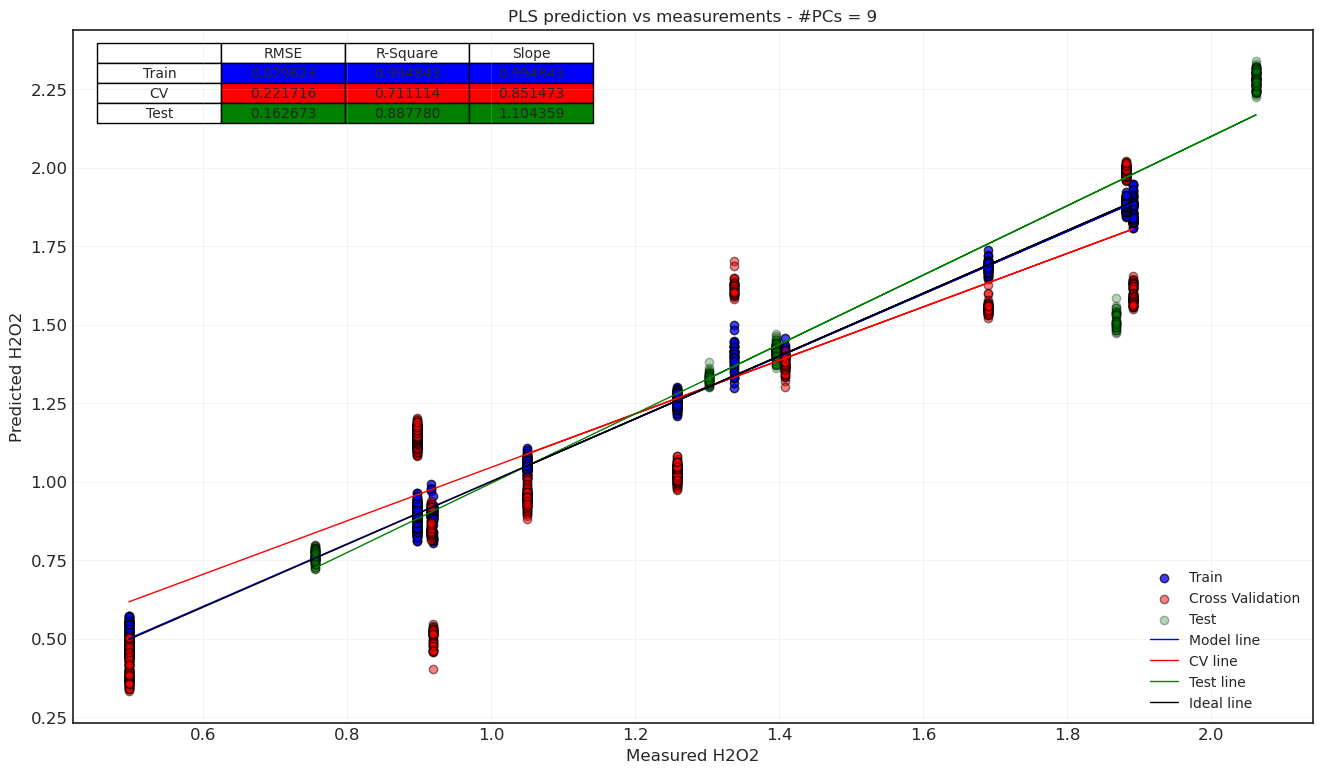

In [2696]:
regression_plot(y_pls[label_to_display], y_pred_train[label_to_display],
                y_pred_cv[label_to_display], y_pls_test[label_to_display],
                y_pred_test[label_to_display], rmse_train, r2_train,
                rmse_cv, r2_cv, rmse_test, r2_test,
                title = f"PLS prediction vs measurements - #PCs = {pls.best_estimator_.n_components}",
                variable = label_to_display)

In [2697]:
print(y.columns.tolist())

['FluidT', 'SpectrT', 'ExpTime', 'H2O2', 'Cu', 'pH', 'A', 'H2O']


In [2698]:
selected_labels = ['H2O2']
label_to_display = 'H2O2'
x_pls = x_train
y_pls = y_train[selected_labels]
y_pls_test = y_test[selected_labels] 

print(f'The features matrix to be modeled x_pls shape: {x_pls.shape}')
print(f'The labels matrix to be modeled y_pls shape: {y_pls.shape}')

The features matrix to be modeled x_pls shape: (1544, 100)
The labels matrix to be modeled y_pls shape: (1544, 1)


## Model optimization 

### Outlier detection and removal

1. Outlier sorting using Q residuals and Hotelling's Tsquared

In [2699]:
ncomp = pls.best_estimator_.n_components

# Get X scores
T = pls.best_estimator_.x_scores_

# Get X loadings
P = pls.best_estimator_.x_loadings_
 
# Calculate error array
Err = x_pls - np.dot(T, P.T)
 
# Calculate Q-residuals (sum over the rows of the error array)
Q = np.sum(Err**2, axis=1)
 
# Calculate Hotelling's T-squared (note that data are normalised by default)
Tsq = np.sum((T/np.std(T, axis=0))**2, axis=1)

# set the confidence level
conf = 0.95
 

# Calculate confidence level for T-squared from the ppf of the F distribution
Tsq_conf =  f.ppf(q=conf, dfn=ncomp, \
            dfd=(x_pls.shape[0]-ncomp))*ncomp*(x_pls.shape[0]-1)/(x_pls.shape[0]-ncomp)
 
# Estimate the confidence level for the Q-residuals
i = np.max(Q)+1
while 1-np.sum(Q>i)/np.sum(Q>0)> conf:
    i -= 1
Q_conf = i

2. Visualize the outliers

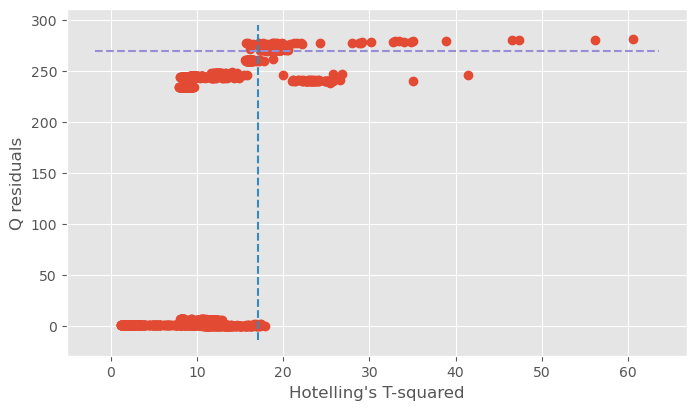

In [2700]:
ax = plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(Tsq, Q, 'o')
    plt.plot([Tsq_conf,Tsq_conf],[plt.axis()[2],plt.axis()[3]],  '--')
    plt.plot([plt.axis()[0],plt.axis()[1]],[Q_conf,Q_conf],  '--')
    plt.xlabel("Hotelling's T-squared")
    plt.ylabel('Q residuals')
 
plt.show()

3. Sort the data according to RMS distance from origin in descending order

In [2701]:
# Sort the RMS distance from the origin in descending order (largest first)
plscomp=pls.best_estimator_.n_components
 
rms_dist = np.flip(np.argsort(np.sqrt(Q**2+Tsq**2)), axis=0)
 
# Sort calibration spectra according to descending RMS distance
Xc = x_pls.iloc[rms_dist, :]
Yc = y_pls.iloc[rms_dist, :]
 
# Discard one outlier at a time up to the value max_outliers
# and calculate the mse cross-validation of the PLS model
max_outliers = 200
 
# Define empty mse array
rmse = np.zeros(max_outliers)
 
for j in range(max_outliers):
 
    pls_temp = PLSRegression(n_components=plscomp, scale=True)
    pls_temp.fit(Xc.iloc[j:, :], Yc.iloc[j:, :])
    group_kfold = GroupKFold(n_splits=Yc[label_to_display].iloc[j:].nunique() - 1)
    y_cv = cross_val_predict(pls_temp, Xc.iloc[j:, :], Yc.iloc[j:, :], groups=Yc[label_to_display].iloc[j:], cv=group_kfold) 
 
    rmse[j] = np.sqrt(mean_squared_error(Yc[label_to_display].iloc[j:], y_cv))
 
# Find the position of the minimum in the mse (excluding the zeros)
rmsemin = np.where(rmse==np.min(rmse[np.nonzero(rmse)]))[0][0]
rmsemin_index = np.argmin(rmse, axis=0)

In [2702]:
print(f'Removed {rmsemin_index} outliers')

Removed 34 outliers


4. Create features and labels matrices without the outliers

In [2703]:
x_outliers_removed = Xc.iloc[rmsemin_index:, :]
y_outliers_removed = Yc.iloc[rmsemin_index:, :]

print('Features matrix rows without outliers: ', x_outliers_removed.shape[0])
print('Labels matrix rows without outliers: ', y_outliers_removed.shape[0])

Features matrix rows without outliers:  1510
Labels matrix rows without outliers:  1510


5. Repeat the steps of PLS regression on the filtered data

In [2704]:
x_pls2_train = x_outliers_removed
y_pls2_train = y_outliers_removed

In [2705]:
print(f'The features matrix to be modeled x_pls2_train shape: {x_pls2_train.shape}')
print(f'The labels matrix to be modeled y_pls2_train shape: {y_pls2_train.shape}')

The features matrix to be modeled x_pls2_train shape: (1510, 100)
The labels matrix to be modeled y_pls2_train shape: (1510, 1)


### Finding the best number of components for the model

1. Define the parameter space for the search

2. Define the grid-search estimator based on PLS regression

* define group k-fold

In [2706]:
# Define GroupKFold cross-validation
group_kfold = GroupKFold(n_splits=y_pls2_train[label_to_display].nunique())
print(f'Group K-Fold: {group_kfold}')

Group K-Fold: GroupKFold(n_splits=11)


In [2707]:
pls2 = GridSearchCV(PLSRegression(scale=False), parameters, scoring = 'neg_mean_squared_error', verbose=1, cv=group_kfold)

3. fit the model to the training data

In [2708]:
pls2.fit(x_pls2_train, y_pls2_train, groups=y_pls2_train[label_to_display])

Fitting 11 folds for each of 19 candidates, totalling 209 fits


GridSearchCV(cv=GroupKFold(n_splits=11), estimator=PLSRegression(scale=False),
             param_grid={'n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='neg_mean_squared_error', verbose=1)

4. The best estimator result

In [2709]:
print(f'The number of components for the PLS model: \n{pls2.best_estimator_}')

The number of components for the PLS model: 
PLSRegression(n_components=7, scale=False)


4. Self prediction results

In [2710]:
y_pred_train2 = pls2.predict(x_pls2_train)
y_pred_train2 = pd.DataFrame(y_pred_train2, columns=selected_labels)

print(f'The self prediction matrix y_pred_train shape: {y_pred_train2.shape}')

The self prediction matrix y_pred_train shape: (1510, 1)


In [2711]:
rmse_train2, r2_train2 = np.sqrt(mean_squared_error(y_pls2_train[label_to_display], y_pred_train2[label_to_display])), \
r2_score(y_pls2_train[label_to_display], y_pred_train2[label_to_display])

### Applying cross validation for the model using the best estimator

1. Apply the best estimator to calculate a cross-validation predicted variable

In [2712]:
y_pred_cv2 = cross_val_predict(pls2.best_estimator_, x_pls2_train, y_pls2_train, groups=y_pls2_train[label_to_display], cv=group_kfold)
y_pred_cv2 = pd.DataFrame(y_pred_cv2, columns=selected_labels)

print(f'The cross-validation prediction matrix y_cv shape: {y_pred_cv2.shape}')

The cross-validation prediction matrix y_cv shape: (1510, 1)


2. Calculate figures of merit

In [2713]:
rmse_cv2, r2_cv2 = np.sqrt(mean_squared_error(y_pls2_train[label_to_display], y_pred_cv2[label_to_display])), \
r2_score(y_pls2_train[label_to_display], y_pred_cv2[label_to_display])

### Validating the model using Test dataset

In [2714]:
y_pred_test2 = pls2.predict(x_test)
y_pred_test2 = pd.DataFrame(y_pred_test2, columns=selected_labels)

In [2715]:
rmse_test2, r2_test2 = np.sqrt(mean_squared_error(y_pls_test[label_to_display], y_pred_test2[label_to_display])), \
r2_score(y_pls_test[label_to_display], y_pred_test2[label_to_display])

3. Plot the results

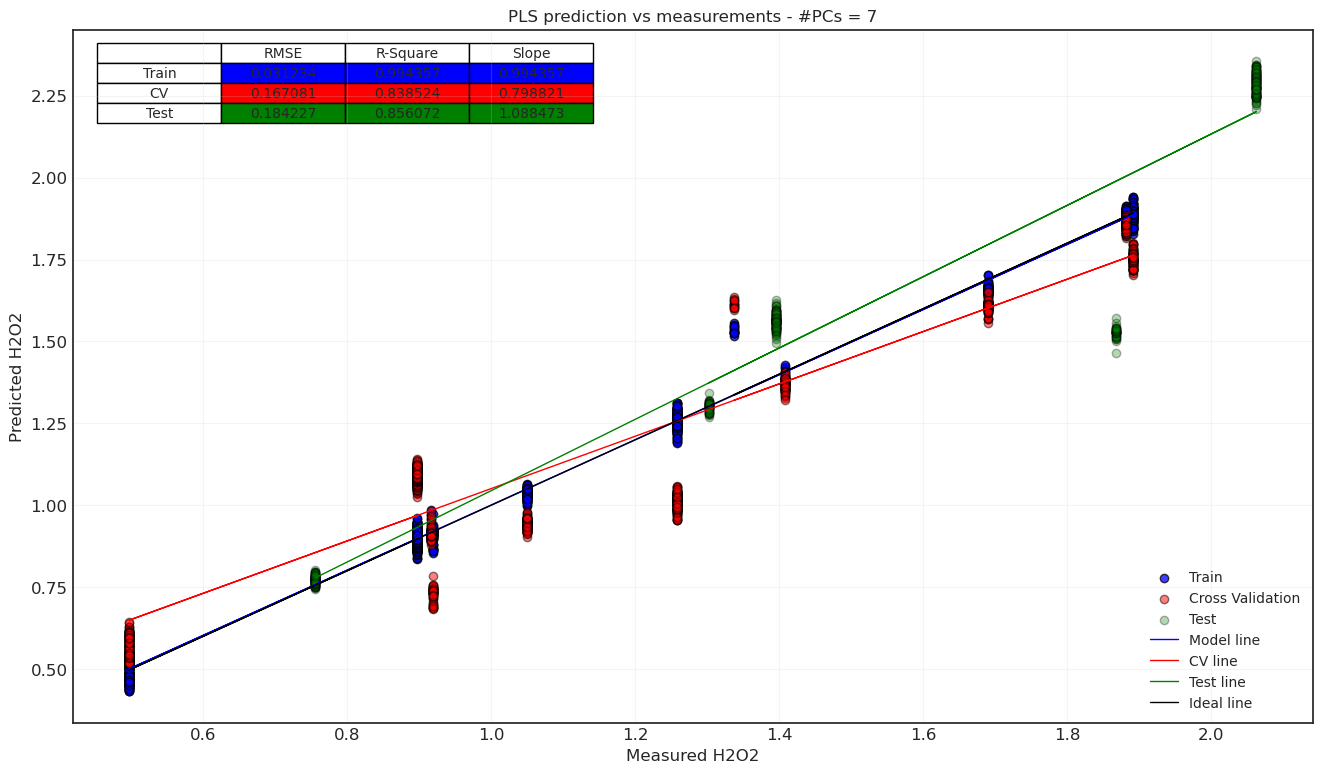

In [2716]:
regression_plot(y_pls2_train[label_to_display], y_pred_train2[label_to_display],
                y_pred_cv2[label_to_display], y_pls_test[label_to_display],
                y_pred_test2[label_to_display], rmse_train2, r2_train2,
                rmse_cv2, r2_cv2, rmse_test2, r2_test2,
                title = f"PLS prediction vs measurements - #PCs = {pls2.best_estimator_.n_components}",
                variable = label_to_display)

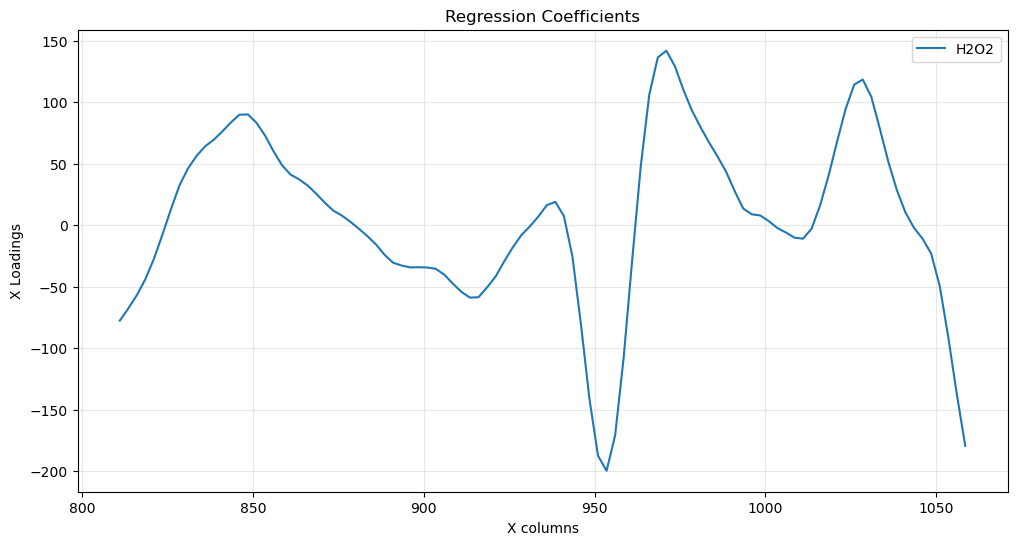

In [2717]:
for i, _label in enumerate(selected_labels):
    if label_to_display == _label:
        break
plt.plot(X.columns, pls2.best_estimator_.coef_[i], label=label_to_display)
plt.xlabel('X columns')
plt.ylabel('X Loadings')
plt.title('Regression Coefficients')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Final results

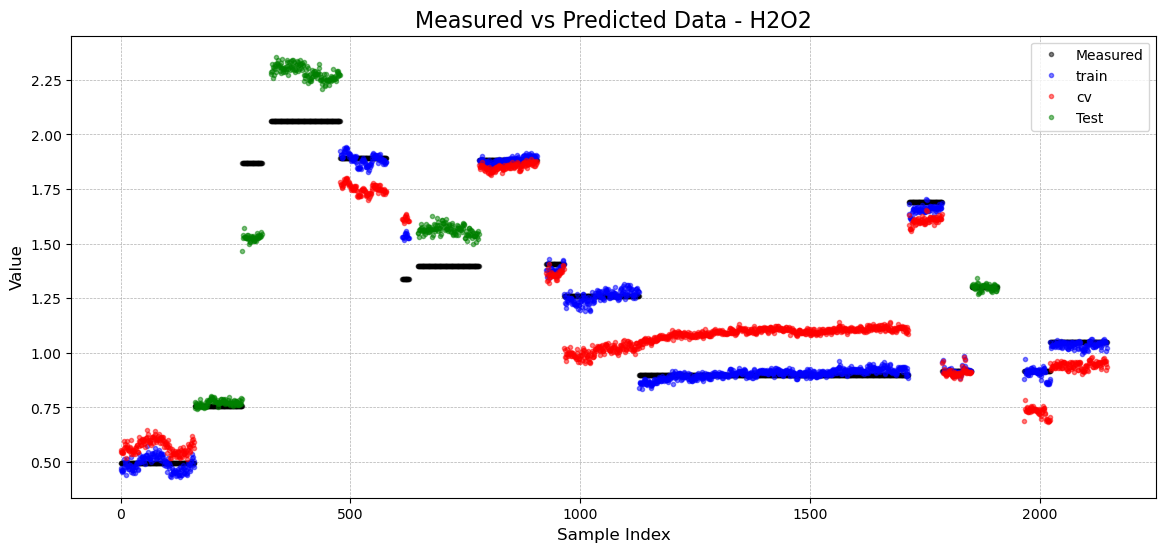

In [2727]:
plt.figure(figsize=(14, 6))

plt.plot(y_pls2_train.index, y_pls2_train[label_to_display],
         'ok', markersize=3, label=f"Measured", alpha=0.5)
plt.plot(y_test.index, y_test[label_to_display],
         'ok', markersize=3, alpha=0.5)
plt.plot(y_pls2_train.index, y_pred_train2[label_to_display],
         'ob', markersize=3, label=f"train", alpha=0.5)
plt.plot(y_pls2_train.index, y_pred_cv2[label_to_display],
         'or', markersize=3, label=f"cv", alpha=0.5)
plt.plot(y_test.index, y_pred_test2[label_to_display],
         'og', markersize=3, label=f"Test", alpha=0.5)

# Add title and labels
plt.title(f'Measured vs Predicted Data - {label_to_display}', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend
plt.legend(loc='best', fontsize=10)

plt.show()

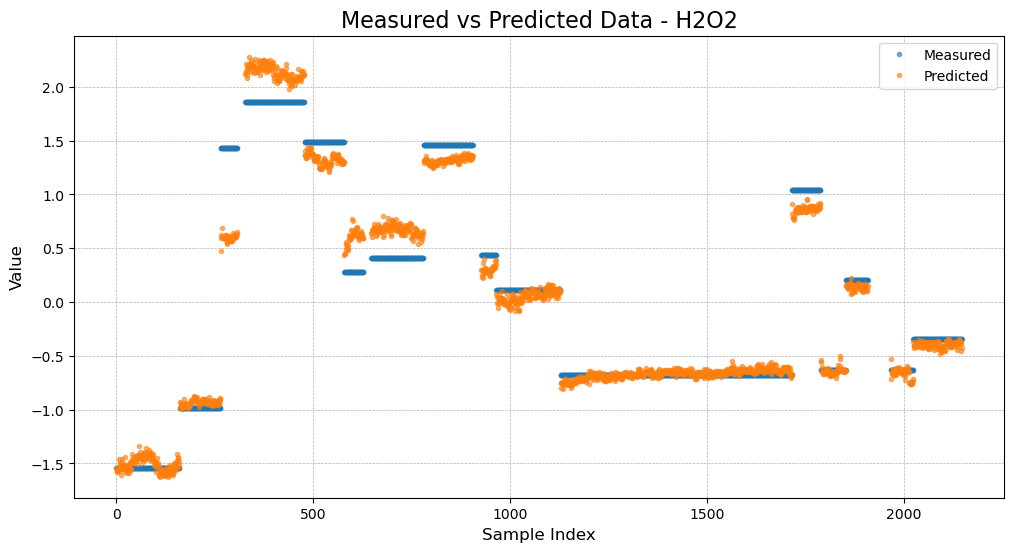

In [2726]:
for i, _label in enumerate(selected_labels):
    if label_to_display == _label:
        break
        
coeff = pls2.best_estimator_.coef_[i]
intercept = pls2.best_estimator_.intercept_[i]

y_measured = scale(y_filtered[label_to_display])
y_predicted = scale(X_filtered @ coeff.T + intercept)

plt.plot(y_filtered.index, y_measured, 'o', markersize=3, label="Measured", alpha=0.6)
plt.plot(X_filtered.index, y_predicted, 'o', markersize=3, label="Predicted", alpha=0.6)

# Add title and labels
plt.title(f'Measured vs Predicted Data - {label_to_display}', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend
plt.legend(loc='best', fontsize=10)
plt.show()

In [2760]:
dict = {'Measured': y_measured,
       'Predicted': y_predicted}
results_df = pd.DataFrame(dict)

# Group the data by the 'Measured' column
grouped = results_df.groupby('Measured')
display((grouped['Predicted'].mean() - grouped['Measured'].mean()) / grouped['Measured'].mean())

Measured
-1.544448   -0.024869
-0.982329   -0.048750
-0.674456   -0.012770
-0.633855    0.008535
-0.627776    0.055028
-0.345522    0.150877
 0.108689   -0.518211
 0.203786   -0.321305
 0.280212    1.154046
 0.406140    0.650099
 0.435451   -0.309897
 1.045553   -0.175340
 1.432023   -0.581846
 1.461334   -0.097171
 1.484783   -0.107069
 1.854752    0.153062
dtype: float64

In [2764]:
display(grouped['Predicted'].mean())
display(grouped['Measured'].mean())

Measured
-1.544448   -1.506039
-0.982329   -0.934440
-0.674456   -0.665843
-0.633855   -0.639265
-0.627776   -0.662321
-0.345522   -0.397654
 0.108689    0.052365
 0.203786    0.138309
 0.280212    0.603589
 0.406140    0.670172
 0.435451    0.300506
 1.045553    0.862226
 1.432023    0.598806
 1.461334    1.319334
 1.484783    1.325808
 1.854752    2.138644
Name: Predicted, dtype: float64

Measured
-1.544448   -1.544448
-0.982329   -0.982329
-0.674456   -0.674456
-0.633855   -0.633855
-0.627776   -0.627776
-0.345522   -0.345522
 0.108689    0.108689
 0.203786    0.203786
 0.280212    0.280212
 0.406140    0.406140
 0.435451    0.435451
 1.045553    1.045553
 1.432023    1.432023
 1.461334    1.461334
 1.484783    1.484783
 1.854752    1.854752
Name: Measured, dtype: float64